# 0. 라이브러리 import

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Augmentation 데이터셋 준비 
---
- 두가지 방법을 사용할 것이다.
1. CutMix
2. Mixup (시간이 남는 다면 시도)  
<br>  
- CutMix가 Mixup보다 성능이 좋기 때문에 CutMix를 먼저 시도
    ![image](https://user-images.githubusercontent.com/48716219/96831035-4bc81680-1477-11eb-9132-b95848c002c3.png)


## 1-1) CutMix란?
---
- [논문링크](https://arxiv.org/pdf/1905.04899.pdf)
- 간단하게 데이터를 자르고 섞는다.
- 위에 사진처럼 사진데이터를 잘라서 섞고 라벨에 대한 값 또한 전체사진에 차지하는 비율만큼 라벨을 새로 만들어 준다.

## 1-2) 데이터셋 불러오기

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


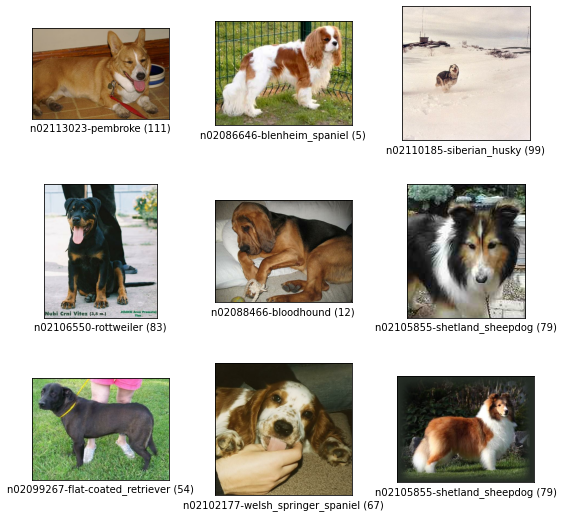

In [4]:
fig = tfds.show_examples(ds_info, ds_train)

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

## 1-3) 이미지 섞기

#### 두개의 이미지 선택

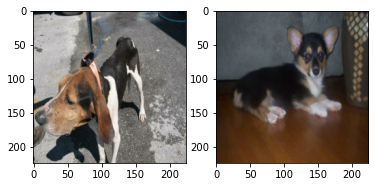

In [8]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

#### a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수

In [9]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [10]:
xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(170, shape=(), dtype=int32) tf.Tensor(84, shape=(), dtype=int32) tf.Tensor(190, shape=(), dtype=int32) tf.Tensor(104, shape=(), dtype=int32)


#### 위에서 추출한 bouding box의 점을 가지고 이미지를 섞는다

In [11]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

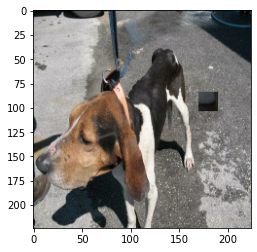

In [12]:
mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

## 1-3) 라벨 섞기
---
- 이미지를 섞었다면 라벨도 이에 맞춰서 섞어줘야한다
- 면적에 비례해서 라벨을 섞어야 한다
- 섞인 이미지의 전체 이미지 비율을 계산해서 두 가지 라벨의 비율로 더해준다

In [13]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label



In [14]:
mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.99202806, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

## 1-4) ```cutmix()``` 함수 구현
- 위에서 구현한 두 함수, ```mix_2_images()```, ```mix_2_label()```를 활용해서 배치단위의 함수 선언

```python
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        image_b = image[tf.cast(tf.random.uniform([],0, batch_size),tf.int32)]
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_label = tf.reshape(tf.stack(mixed_label),(batch_size, num_classes))
    return mixed_imgs, mixed_label
```

In [15]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

## 1-5) 수정된 ```apply_normalize_on_dataset()```
---
- CutMix는 ```batch()``` 함수 뒤에 오도록 만들어야 한다.
    - CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 한다.

In [16]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    return image,label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
#     label = tf.reshape(tf.stack(label),(batch_size, num_classes))
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [17]:
num_classes = ds_info.features["label"].num_classes

In [18]:
apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=False, with_cutmix=True)

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

# 2. 모델 생성 및 훈련
---
- 비교를 위해서 두 가지 모델을 만든다.
    1. ResNet50 with normal data
    2. ResNet50 with augmented data
    3. ResNet50 with cutmix data

## 2-1) 데이터 준비
---
1. ds_train_normal
2. ds_train_aug
3. ds_train_cutmix
4, ds_test

### 하이퍼파라미터

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

lr = 0.005
batch_size = 16

es_3 = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
es_5 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
es = es_5

steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size)
validation_steps=int(ds_info.splits['test'].num_examples/batch_size)
epochs=20

In [20]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_normal = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=False,
)
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=False,
)
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=True,
)
ds_train_all = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=True
)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 2-2) 모델
---
- 총 4가지 학습을 시도
    1. ```resnet50``` : Augmentation X, CutMix X
    2. ```resnet50_aug``` : Augmentation O, CutMix X
    3. ```resnet50_cutmix``` : Augmentation X, CutMix O
    4. ```renset50_all``` : Augmentation O, CutMix O

### 모델 생성 및 학습
---
- Learning rate : 0.005
- callback : EarlyStopping, patience=5
- 메모리 때문에 모델들은 학습을 마치고 ```del```을 사용해서 삭제시켜준 후 새로운 모델을 생성

In [ ]:
tf.random.set_seed(1994)

#### ResNet50, Normal Data

In [22]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_normal = resnet50.fit(
    ds_train_normal, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 124s 165ms/step - loss: 2.6389 - accuracy: 0.3870 - val_loss: 3.5748 - val_accuracy: 0.1771
Epoch 2/20
750/750 [==============================] - 128s 171ms/step - loss: 1.0246 - accuracy: 0.7292 - val_loss: 1.1110 - val_accuracy: 0.6742
Epoch 3/20
750/750 [==============================] - 120s 160ms/step - loss: 0.5362 - accuracy: 0.8752 - val_loss: 0.9847 - val_accuracy: 0.7090
Epoch 4/20
750/750 [==============================] - 120s 160ms/step - loss: 0.2297 - accuracy: 0.9625 - val_loss: 0.9280 - val_accuracy: 0.7269
Epoch 5/20
750/750 [==============================] - 120s 161ms/step - loss: 0.1397 - accuracy: 0.9855 - val_loss: 0.9591 - val_accuracy: 0.7179
Epoch 6/20
750/750 [==============================] - 125s 166ms/step - loss: 0.0969 - accuracy: 0.9920 - val_loss: 0.9511 - val_accuracy: 0.7262
Epoch 7/20
750/750 [==============================] - 166s 221ms/step - loss: 0.0411 - accuracy: 0.9986 - val_loss: 0.9623 -

In [24]:
del resnet50

#### ResNet50, Augmented data

In [25]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [26]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
   ds_train_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 128s 171ms/step - loss: 2.7089 - accuracy: 0.3661 - val_loss: 3.3514 - val_accuracy: 0.2083
Epoch 2/20
750/750 [==============================] - 128s 171ms/step - loss: 1.1574 - accuracy: 0.6817 - val_loss: 1.1342 - val_accuracy: 0.6704
Epoch 3/20
750/750 [==============================] - 120s 160ms/step - loss: 0.7293 - accuracy: 0.8044 - val_loss: 1.0177 - val_accuracy: 0.6929
Epoch 4/20
750/750 [==============================] - 121s 162ms/step - loss: 0.4968 - accuracy: 0.8723 - val_loss: 0.9338 - val_accuracy: 0.7228
Epoch 5/20
750/750 [==============================] - 127s 169ms/step - loss: 0.2886 - accuracy: 0.9388 - val_loss: 1.0150 - val_accuracy: 0.7029
Epoch 6/20
750/750 [==============================] - 122s 163ms/step - loss: 0.2000 - accuracy: 0.9628 - val_loss: 0.9032 - val_accuracy: 0.7371
Epoch 7/20
750/750 [==============================] - 129s 172ms/step - loss: 0.1324 - accuracy: 0.9791 - val_loss: 0.9505 -

In [27]:
del aug_resnet50

#### ResNet50, CutMix data

In [28]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [29]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 130s 173ms/step - loss: 4.1203 - accuracy: 0.1572 - val_loss: 3.4438 - val_accuracy: 0.1797
Epoch 2/20
750/750 [==============================] - 132s 176ms/step - loss: 3.1669 - accuracy: 0.3820 - val_loss: 1.3704 - val_accuracy: 0.6191
Epoch 3/20
750/750 [==============================] - 131s 174ms/step - loss: 2.8278 - accuracy: 0.4732 - val_loss: 1.2295 - val_accuracy: 0.6594
Epoch 4/20
750/750 [==============================] - 128s 171ms/step - loss: 2.6274 - accuracy: 0.5335 - val_loss: 1.1024 - val_accuracy: 0.6919
Epoch 5/20
750/750 [==============================] - 125s 167ms/step - loss: 2.4743 - accuracy: 0.5871 - val_loss: 1.0629 - val_accuracy: 0.6958
Epoch 6/20
750/750 [==============================] - 127s 169ms/step - loss: 2.3500 - accuracy: 0.6284 - val_loss: 1.0241 - val_accuracy: 0.7184
Epoch 7/20
750/750 [==============================] - 135s 180ms/step - loss: 2.2378 - accuracy: 0.6598 - val_loss: 1.1287 -

In [30]:
del cutmix_resnet50

#### ResNet50, Augmented + CutMix data

In [31]:
all_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [32]:
all_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_all = all_resnet50.fit(
    ds_train_all, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 135s 180ms/step - loss: 4.1463 - accuracy: 0.1488 - val_loss: 3.4180 - val_accuracy: 0.2008
Epoch 2/20
750/750 [==============================] - 133s 178ms/step - loss: 3.1934 - accuracy: 0.3657 - val_loss: 1.3635 - val_accuracy: 0.6236
Epoch 3/20
750/750 [==============================] - 133s 177ms/step - loss: 2.8853 - accuracy: 0.4572 - val_loss: 1.2703 - val_accuracy: 0.6538
Epoch 4/20
750/750 [==============================] - 133s 177ms/step - loss: 2.7041 - accuracy: 0.5077 - val_loss: 1.0930 - val_accuracy: 0.6853
Epoch 5/20
750/750 [==============================] - 133s 177ms/step - loss: 2.5828 - accuracy: 0.5437 - val_loss: 1.1854 - val_accuracy: 0.6711
Epoch 6/20
750/750 [==============================] - 133s 178ms/step - loss: 2.4538 - accuracy: 0.5847 - val_loss: 1.1997 - val_accuracy: 0.6683
Epoch 7/20
750/750 [==============================] - 133s 177ms/step - loss: 2.3557 - accuracy: 0.6173 - val_loss: 0.9855 -

In [33]:
del all_resnet50

## 2-3) 결과 비교

### 그래프 시각화

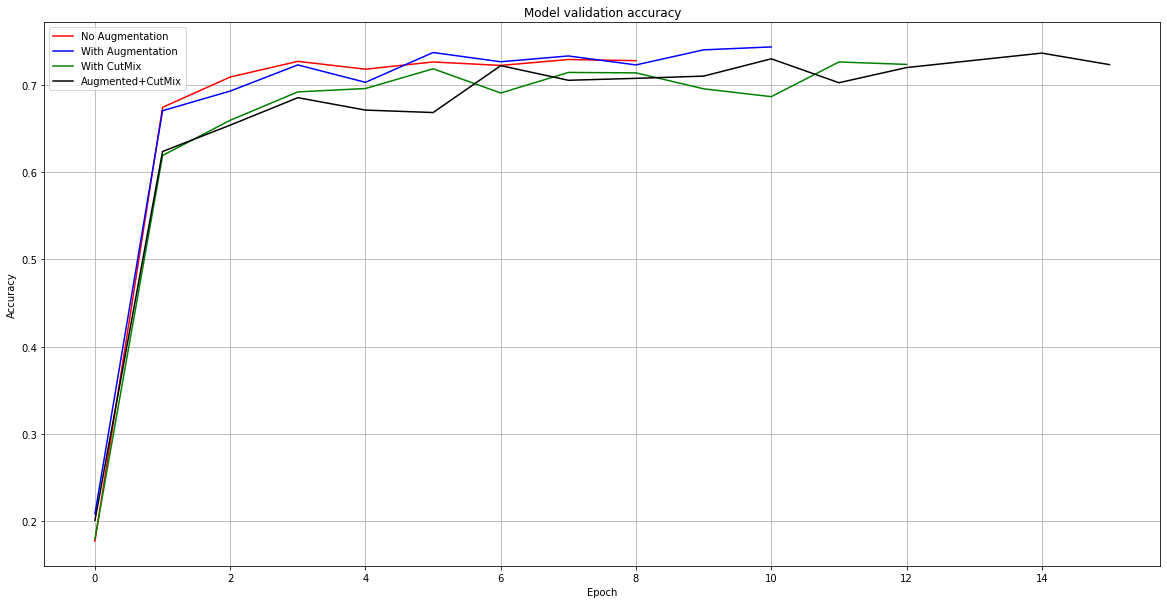

In [50]:
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_normal.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_all.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix'], loc='best')
plt.grid(True)
plt.savefig('fig1_Accuracy.png')
plt.show()

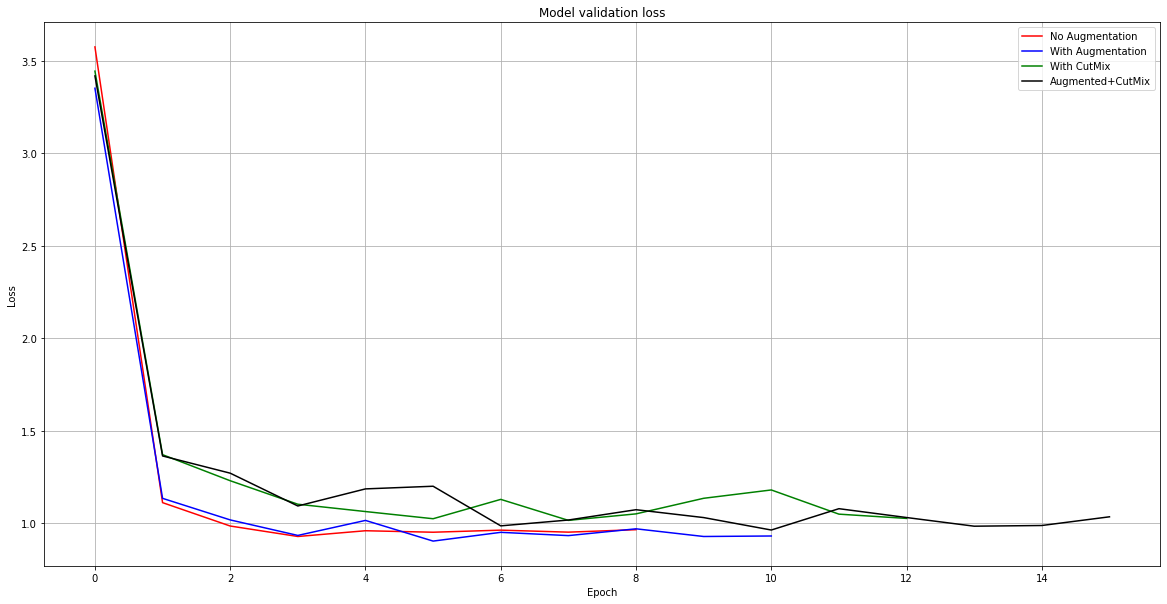

In [51]:
plt.figure(figsize=(20,10))
plt.plot(history_resnet50_normal.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_all.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix'], loc='best')
plt.grid(True)
plt.savefig('fig1_loss.png')
plt.show()

### 수치 비교
---
1. 첫번째 시도  
    - 그래프 시각화  
        - accuracy
            ![fig1_Accuracy](https://user-images.githubusercontent.com/48716219/96890933-2103af80-14c3-11eb-808a-32f9cb733ad2.png)
    - Augmentation함수
        ```python
        def augment(image, label):
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.2)
            return image, label
        ```  
    - Accuracy 결과
        ```python
        Augmentation X, CutMix X Data's best accuracy : 0.729
        Augmentation O, CutMix X Data's best accuracy : 0.743
        Augmentation X, CutMix O Data's best accuracy : 0.726
        Augmentation O, CutMix O Data's best accuracy : 0.736
        ```  
        <br>  
    - 일반 데이터나 CutMix한 데이터나 Augmentation을 수행했을 때, Accuracy는 올라갔다.
        - 정확도상승률은 <b><font color=red>1.9%</b></font>
    - 하지만 CutMix가 더 높을 줄 알았던 정확도는 생각보다 원래 데이터에 비해서 더 높은 편은 아니였다.
        - Augmentation을 수행하지 않았을 경우, 정확도의 차이는 <b><font color=red>0.003</b></font> 차이로 일반 데이터가 더 높았다.
        - Augmentation을 수행했을 경우, 정확도의 차이는 <b><font color=red>0.007</b></font> 차이로 일반 데이터가 더 높았다.
---

In [49]:
print(f"Augmentation X, CutMix X Data's best accuracy : {round(max(history_resnet50_normal.history['val_accuracy']), 3)}")
print(f"Augmentation O, CutMix X Data's best accuracy : {round(max(history_resnet50_aug.history['val_accuracy']), 3)}")
print(f"Augmentation X, CutMix O Data's best accuracy : {round(max(history_resnet50_cutmix.history['val_accuracy']), 3)}")
print(f"Augmentation O, CutMix O Data's best accuracy : {round(max(history_resnet50_all.history['val_accuracy']), 3)}")

Augmentation X, CutMix X Data's best accuracy : 0.729
Augmentation O, CutMix X Data's best accuracy : 0.743
Augmentation X, CutMix O Data's best accuracy : 0.726
Augmentation O, CutMix O Data's best accuracy : 0.736
